In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
device= torch.device("cuda"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [5]:
df=pd.read_csv("data/Sunspots.csv",index_col="Date",parse_dates=["Date"])
df

,Monthly_Mean_Sunspot
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


# Dataset Splitting

In [6]:
from sklearn.model_selection import train_test_split

In [7]:

ts_train, ts_test = train_test_split(df, test_size=0.2,shuffle=False)
ts_train.shape, ts_test.shape

((2612, 1), (653, 1))

# Dataset and Dataloader

In [8]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [9]:
seq_len= 14
bs=32

train_set= TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",seq_len)
trainloader=DataLoader(train_set,batch_size=bs)

test_set=TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",seq_len)
testloader= DataLoader(test_set,batch_size=bs)

(N, S, F): (186, 14, 1)
Note: last 7 data excluded

(N, S, F): (46, 14, 1)
Note: last 8 data excluded



# Arsitektur and Config

In [10]:
class GRU (nn.Module):
    def __init__(self,input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.hidden= nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self,x,hidden):
        x,hidden= self.hidden(x,hidden)
        x= self.fc(x)
        return x,hidden

In [11]:
config = set_config({
    "batch_size" : bs,
    "seq_len" : train_set.n_seq,
    "input_size" : train_set.n_feature,
    "output_size" : 1,
    "hidden_size" : 128,
    "num_layers" : 2,
    "dropout": 0
})

# Training Preparation ~> MCOC

In [12]:
model = GRU(config.input_size,config.output_size,config.hidden_size,config.num_layers,config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model,config,outdir="model")


# Training Loop

In [13]:
def loop_fn (mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = 0
    for feature,target in tqdm(dataloader,desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature,None) 
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item()*feature.shape[0]
    cost=cost/len(dataset)
    return cost

In [14]:
from tqdm.auto import tqdm



Epoch     1
Train_cost  = 10916.1847 | Test_cost  = 12076.4855 | 




Epoch     2
Train_cost  = 10517.1152 | Test_cost  = 11693.3879 | 




Epoch     3
Train_cost  = 10224.6089 | Test_cost  = 11455.2075 | 




Epoch     4
Train_cost  = 10042.8207 | Test_cost  = 11287.9071 | 




Epoch     5
Train_cost  = 9900.5268 | Test_cost  = 11140.0288 | 




Epoch     6
Train_cost  = 9769.2434 | Test_cost  = 10999.0286 | 




Epoch     7
Train_cost  = 9643.0694 | Test_cost  = 10862.6714 | 




Epoch     8
Train_cost  = 9520.9494 | Test_cost  = 10730.5042 | 




Epoch     9
Train_cost  = 9402.6129 | Test_cost  = 10602.2897 | 




Epoch    10
Train_cost  = 9287.8398 | Test_cost  = 10477.7489 | 




Epoch    11
Train_cost  = 9176.3531 | Test_cost  = 10356.5523 | 




Epoch    12
Train_cost  = 9067.9050 | Test_cost  = 10238.4813 | 




Epoch    13
Train_cost  = 8962.3151 | Test_cost  = 10123.3591 | 




Epoch    14
Train_cost  = 8859.4144 | Test_cost  = 10010.9878 | 




Epoch    15
Train_cost  = 8759.0239 | Test_cost  = 9901.2041 | 




Epoch    16
Train_cost  = 8661.0125 | Test_cost  = 9793.8851 | 




Epoch    17
Train_cost  = 8565.2611 | Test_cost  = 9688.9109 | 




Epoch    18
Train_cost  = 8471.6606 | Test_cost  = 9586.1783 | 




Epoch    19
Train_cost  = 8380.0772 | Test_cost  = 9485.5233 | 




Epoch    20
Train_cost  = 8290.3351 | Test_cost  = 9386.7772 | 


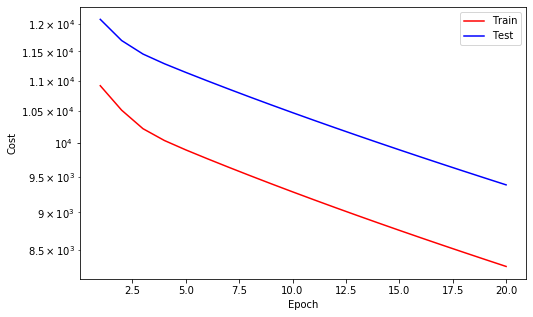



Epoch    21
Train_cost  = 8202.1674 | Test_cost  = 9289.6891 | 




Epoch    22
Train_cost  = 8115.2973 | Test_cost  = 9193.1924 | 




Epoch    23
Train_cost  = 8027.0382 | Test_cost  = 9090.3300 | 




Epoch    24
Train_cost  = 7935.1730 | Test_cost  = 8993.9231 | 




Epoch    25
Train_cost  = 7850.3554 | Test_cost  = 8896.6081 | 




Epoch    26
Train_cost  = 7765.8831 | Test_cost  = 8802.6154 | 




Epoch    27
Train_cost  = 7682.1670 | Test_cost  = 8710.7388 | 




Epoch    28
Train_cost  = 7600.6515 | Test_cost  = 8620.6002 | 




Epoch    29
Train_cost  = 7520.2651 | Test_cost  = 8531.6959 | 




Epoch    30
Train_cost  = 7440.9949 | Test_cost  = 8443.3710 | 




Epoch    31
Train_cost  = 7363.1145 | Test_cost  = 8357.0294 | 




Epoch    32
Train_cost  = 7286.2522 | Test_cost  = 8271.4492 | 




Epoch    33
Train_cost  = 7210.5193 | Test_cost  = 8186.9920 | 




Epoch    34
Train_cost  = 7135.8316 | Test_cost  = 8103.9397 | 




Epoch    35
Train_cost  = 7062.2096 | Test_cost  = 8021.3667 | 




Epoch    36
Train_cost  = 6989.7035 | Test_cost  = 7940.1768 | 




Epoch    37
Train_cost  = 6918.1773 | Test_cost  = 7859.7251 | 




Epoch    38
Train_cost  = 6847.6944 | Test_cost  = 7780.5352 | 




Epoch    39
Train_cost  = 6778.1250 | Test_cost  = 7702.3511 | 




Epoch    40
Train_cost  = 6709.5451 | Test_cost  = 7625.3008 | 


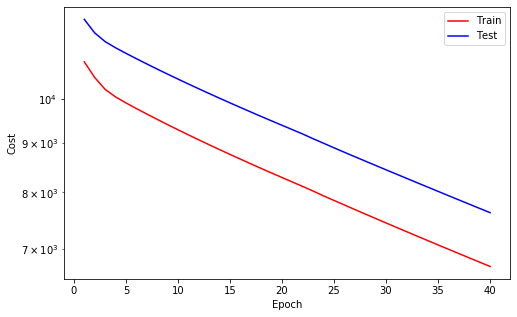



Epoch    41
Train_cost  = 6641.8979 | Test_cost  = 7549.1627 | 




Epoch    42
Train_cost  = 6575.2038 | Test_cost  = 7474.0961 | 




Epoch    43
Train_cost  = 6509.3929 | Test_cost  = 7399.9283 | 




Epoch    44
Train_cost  = 6444.4558 | Test_cost  = 7326.7631 | 




Epoch    45
Train_cost  = 6380.3642 | Test_cost  = 7254.5012 | 




Epoch    46
Train_cost  = 6317.1037 | Test_cost  = 7183.1678 | 




Epoch    47
Train_cost  = 6254.6538 | Test_cost  = 7112.6625 | 




Epoch    48
Train_cost  = 6192.9725 | Test_cost  = 7042.8925 | 




Epoch    49
Train_cost  = 6132.0435 | Test_cost  = 6973.9470 | 




Epoch    50
Train_cost  = 6071.8740 | Test_cost  = 6905.9343 | 




Epoch    51
Train_cost  = 6012.4618 | Test_cost  = 6838.8750 | 




Epoch    52
Train_cost  = 5953.8058 | Test_cost  = 6772.7986 | 




Epoch    53
Train_cost  = 5895.9398 | Test_cost  = 6707.6690 | 




Epoch    54
Train_cost  = 5838.8692 | Test_cost  = 6642.9607 | 




Epoch    55
Train_cost  = 5782.4784 | Test_cost  = 6578.0127 | 




Epoch    56
Train_cost  = 5726.6102 | Test_cost  = 6513.7404 | 




Epoch    57
Train_cost  = 5671.6035 | Test_cost  = 6451.0976 | 




Epoch    58
Train_cost  = 5617.4799 | Test_cost  = 6389.5131 | 




Epoch    59
Train_cost  = 5563.7563 | Test_cost  = 6329.2920 | 




Epoch    60
Train_cost  = 5510.7595 | Test_cost  = 6270.7691 | 


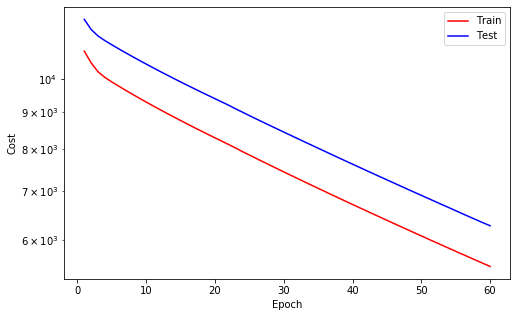



Epoch    61
Train_cost  = 5458.9451 | Test_cost  = 6212.7455 | 




Epoch    62
Train_cost  = 5408.0709 | Test_cost  = 6151.4385 | 




Epoch    63
Train_cost  = 5357.0422 | Test_cost  = 6091.2365 | 




Epoch    64
Train_cost  = 5307.3918 | Test_cost  = 6033.8323 | 




Epoch    65
Train_cost  = 5257.5449 | Test_cost  = 5980.9693 | 




Epoch    66
Train_cost  = 5208.5984 | Test_cost  = 5923.2774 | 




Epoch    67
Train_cost  = 5159.8915 | Test_cost  = 5865.7673 | 




Epoch    68
Train_cost  = 5112.5616 | Test_cost  = 5812.3402 | 




Epoch    69
Train_cost  = 5064.8421 | Test_cost  = 5759.7377 | 




Epoch    70
Train_cost  = 5018.2386 | Test_cost  = 5703.8353 | 




Epoch    71
Train_cost  = 4972.0564 | Test_cost  = 5650.7469 | 




Epoch    72
Train_cost  = 4926.4233 | Test_cost  = 5600.9441 | 




Epoch    73
Train_cost  = 4881.1731 | Test_cost  = 5548.5437 | 




Epoch    74
Train_cost  = 4836.6835 | Test_cost  = 5496.2175 | 




Epoch    75
Train_cost  = 4792.4472 | Test_cost  = 5446.4522 | 




Epoch    76
Train_cost  = 4749.2885 | Test_cost  = 5398.3663 | 




Epoch    77
Train_cost  = 4706.0253 | Test_cost  = 5351.1273 | 




Epoch    78
Train_cost  = 4664.3781 | Test_cost  = 5300.9822 | 




Epoch    79
Train_cost  = 4622.8318 | Test_cost  = 5249.9564 | 




Epoch    80
Train_cost  = 4582.7567 | Test_cost  = 5204.4657 | 


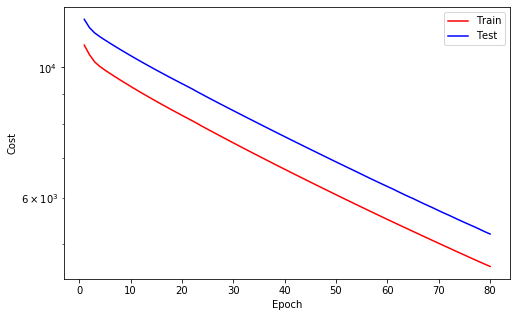



Epoch    81
Train_cost  = 4541.7352 | Test_cost  = 5161.6243 | 




Epoch    82
Train_cost  = 4500.6846 | Test_cost  = 5109.9219 | 




Epoch    83
Train_cost  = 4461.4121 | Test_cost  = 5062.5015 | 




Epoch    84
Train_cost  = 4424.4877 | Test_cost  = 5025.8962 | 




Epoch    85
Train_cost  = 4385.2856 | Test_cost  = 4974.8864 | 




Epoch    86
Train_cost  = 4345.5407 | Test_cost  = 4928.6834 | 




Epoch    87
Train_cost  = 4308.4144 | Test_cost  = 4891.5243 | 




Epoch    88
Train_cost  = 4269.0239 | Test_cost  = 4843.0410 | 




Epoch    89
Train_cost  = 4231.8969 | Test_cost  = 4799.9921 | 




Epoch    90
Train_cost  = 4194.9825 | Test_cost  = 4761.3819 | 




Epoch    91
Train_cost  = 4158.9703 | Test_cost  = 4717.1440 | 




Epoch    92
Train_cost  = 4122.9380 | Test_cost  = 4674.4616 | 




Epoch    93
Train_cost  = 4090.2274 | Test_cost  = 4632.9896 | 




Epoch    94
Train_cost  = 4055.8241 | Test_cost  = 4602.0136 | 




Epoch    95
Train_cost  = 4020.7291 | Test_cost  = 4555.5342 | 




Epoch    96
Train_cost  = 3985.0448 | Test_cost  = 4513.6617 | 




Epoch    97
Train_cost  = 3952.4348 | Test_cost  = 4476.6707 | 




Epoch    98
Train_cost  = 3917.9543 | Test_cost  = 4441.7057 | 




Epoch    99
Train_cost  = 3885.3050 | Test_cost  = 4399.6534 | 




Epoch   100
Train_cost  = 3853.1236 | Test_cost  = 4360.4337 | 


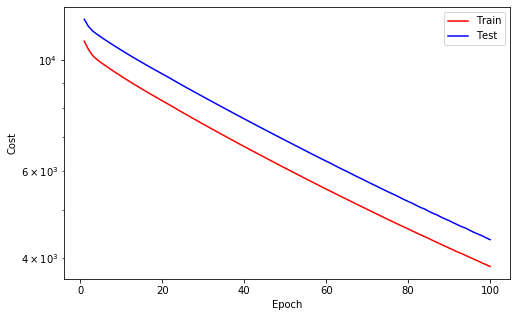



Epoch   101
Train_cost  = 3821.6659 | Test_cost  = 4324.9186 | 




Epoch   102
Train_cost  = 3789.0644 | Test_cost  = 4290.0615 | 




Epoch   103
Train_cost  = 3755.9688 | Test_cost  = 4252.3893 | 




Epoch   104
Train_cost  = 3724.5263 | Test_cost  = 4215.2784 | 




Epoch   105
Train_cost  = 3694.8797 | Test_cost  = 4181.2842 | 




Epoch   106
Train_cost  = 3666.9928 | Test_cost  = 4145.3360 | 




Epoch   107
Train_cost  = 3637.9248 | Test_cost  = 4120.6832 | 




Epoch   108
Train_cost  = 3609.7925 | Test_cost  = 4083.8261 | 




Epoch   109
Train_cost  = 3581.8747 | Test_cost  = 4039.0967 | 




Epoch   110
Train_cost  = 3555.3269 | Test_cost  = 4014.2522 | 




Epoch   111
Train_cost  = 3524.7970 | Test_cost  = 3979.8925 | 




Epoch   112
Train_cost  = 3495.8221 | Test_cost  = 3941.8519 | 




Epoch   113
Train_cost  = 3469.5547 | Test_cost  = 3915.9738 | 




Epoch   114
Train_cost  = 3441.4282 | Test_cost  = 3879.8385 | 




Epoch   115
Train_cost  = 3415.0954 | Test_cost  = 3847.5260 | 




Epoch   116
Train_cost  = 3388.3434 | Test_cost  = 3821.7335 | 




Epoch   117
Train_cost  = 3360.3159 | Test_cost  = 3786.6299 | 




Epoch   118
Train_cost  = 3334.2806 | Test_cost  = 3755.5317 | 




Epoch   119
Train_cost  = 3307.3384 | Test_cost  = 3731.0030 | 




Epoch   120
Train_cost  = 3282.0655 | Test_cost  = 3699.3627 | 


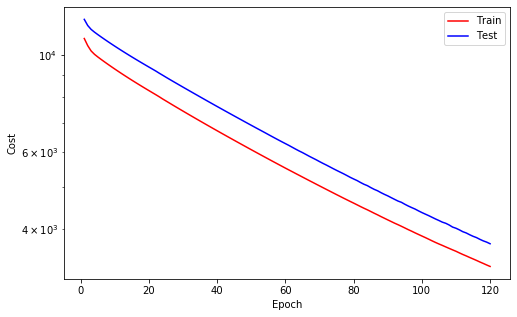



Epoch   121
Train_cost  = 3256.2602 | Test_cost  = 3664.2881 | 




Epoch   122
Train_cost  = 3231.8704 | Test_cost  = 3638.5155 | 




Epoch   123
Train_cost  = 3207.6196 | Test_cost  = 3616.4004 | 




Epoch   124
Train_cost  = 3183.9109 | Test_cost  = 3587.6726 | 




Epoch   125
Train_cost  = 3159.6498 | Test_cost  = 3551.5560 | 




Epoch   126
Train_cost  = 3135.8850 | Test_cost  = 3523.4127 | 




Epoch   127
Train_cost  = 3115.3080 | Test_cost  = 3506.3507 | 




Epoch   128
Train_cost  = 3092.5078 | Test_cost  = 3482.4453 | 




Epoch   129
Train_cost  = 3068.8439 | Test_cost  = 3443.5216 | 




Epoch   130
Train_cost  = 3043.9015 | Test_cost  = 3417.0390 | 




Epoch   131
Train_cost  = 3021.0701 | Test_cost  = 3396.9612 | 




Epoch   132
Train_cost  = 3000.0779 | Test_cost  = 3375.2282 | 




Epoch   133
Train_cost  = 2978.0936 | Test_cost  = 3342.3560 | 




Epoch   134
Train_cost  = 2953.8108 | Test_cost  = 3314.7705 | 




Epoch   135
Train_cost  = 2933.2178 | Test_cost  = 3288.7685 | 




Epoch   136
Train_cost  = 2913.4167 | Test_cost  = 3278.6237 | 




Epoch   137
Train_cost  = 2895.7701 | Test_cost  = 3258.5948 | 




Epoch   138
Train_cost  = 2873.9146 | Test_cost  = 3217.1791 | 




Epoch   139
Train_cost  = 2852.6368 | Test_cost  = 3194.9448 | 




Epoch   140
Train_cost  = 2831.3825 | Test_cost  = 3172.7860 | 


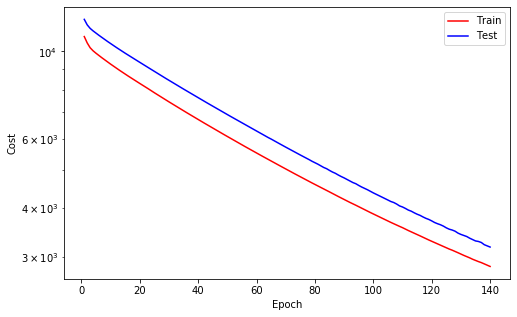



Epoch   141
Train_cost  = 2812.3392 | Test_cost  = 3160.9097 | 




Epoch   142
Train_cost  = 2795.0974 | Test_cost  = 3133.1604 | 




Epoch   143
Train_cost  = 2774.5366 | Test_cost  = 3098.6944 | 




Epoch   144
Train_cost  = 2754.0162 | Test_cost  = 3087.2996 | 




Epoch   145
Train_cost  = 2734.4622 | Test_cost  = 3064.5943 | 




Epoch   146
Train_cost  = 2712.8898 | Test_cost  = 3035.7511 | 




Epoch   147
Train_cost  = 2692.9362 | Test_cost  = 3016.5515 | 




Epoch   148
Train_cost  = 2673.4779 | Test_cost  = 2999.9905 | 




Epoch   149
Train_cost  = 2655.6375 | Test_cost  = 2975.6124 | 




Epoch   150
Train_cost  = 2636.3228 | Test_cost  = 2953.8724 | 




Epoch   151
Train_cost  = 2617.6168 | Test_cost  = 2935.8613 | 




Epoch   152
Train_cost  = 2599.9543 | Test_cost  = 2920.8723 | 




Epoch   153
Train_cost  = 2582.3138 | Test_cost  = 2894.8763 | 




Epoch   154
Train_cost  = 2564.7544 | Test_cost  = 2872.1452 | 




Epoch   155
Train_cost  = 2549.1994 | Test_cost  = 2855.7817 | 




Epoch   156
Train_cost  = 2531.4811 | Test_cost  = 2842.5444 | 




Epoch   157
Train_cost  = 2516.3174 | Test_cost  = 2811.6296 | 




Epoch   158
Train_cost  = 2497.2906 | Test_cost  = 2795.3433 | 




Epoch   159
Train_cost  = 2482.7046 | Test_cost  = 2773.1918 | 




Epoch   160
Train_cost  = 2464.9369 | Test_cost  = 2763.1951 | 


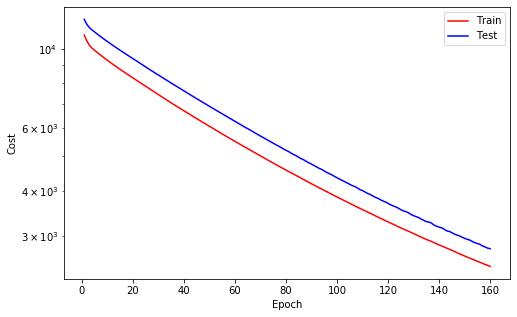



Epoch   161
Train_cost  = 2447.9856 | Test_cost  = 2744.5291 | 




Epoch   162
Train_cost  = 2432.9608 | Test_cost  = 2723.6372 | 




Epoch   163
Train_cost  = 2417.8621 | Test_cost  = 2701.3531 | 




Epoch   164
Train_cost  = 2401.3671 | Test_cost  = 2684.3493 | 




Epoch   165
Train_cost  = 2387.9313 | Test_cost  = 2662.9188 | 




Epoch   166
Train_cost  = 2372.6729 | Test_cost  = 2655.5324 | 




Epoch   167
Train_cost  = 2358.6425 | Test_cost  = 2627.6323 | 




Epoch   168
Train_cost  = 2340.1543 | Test_cost  = 2610.6140 | 




Epoch   169
Train_cost  = 2325.9057 | Test_cost  = 2598.5072 | 




Epoch   170
Train_cost  = 2310.6694 | Test_cost  = 2579.7347 | 




Epoch   171
Train_cost  = 2296.0546 | Test_cost  = 2559.4323 | 




Epoch   172
Train_cost  = 2281.7292 | Test_cost  = 2548.3691 | 




Epoch   173
Train_cost  = 2269.4349 | Test_cost  = 2521.4861 | 




Epoch   174
Train_cost  = 2253.4121 | Test_cost  = 2511.3746 | 




Epoch   175
Train_cost  = 2240.2743 | Test_cost  = 2499.6591 | 




Epoch   176
Train_cost  = 2227.8321 | Test_cost  = 2474.3946 | 




Epoch   177
Train_cost  = 2210.8103 | Test_cost  = 2461.4136 | 




Epoch   178
Train_cost  = 2196.9278 | Test_cost  = 2442.4010 | 




Epoch   179
Train_cost  = 2181.7416 | Test_cost  = 2431.1462 | 




Epoch   180
Train_cost  = 2165.4162 | Test_cost  = 2421.4485 | 


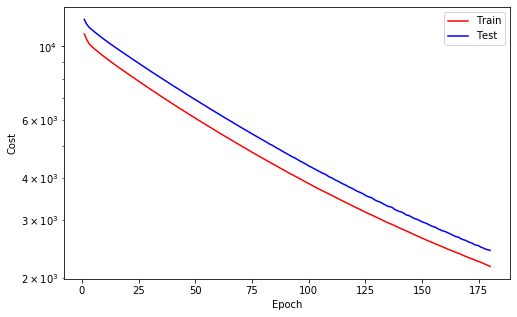



Epoch   181
Train_cost  = 2153.1528 | Test_cost  = 2401.4935 | 




Epoch   182
Train_cost  = 2139.7140 | Test_cost  = 2387.6154 | 




Epoch   183
Train_cost  = 2124.6923 | Test_cost  = 2363.0147 | 




Epoch   184
Train_cost  = 2111.3486 | Test_cost  = 2355.2829 | 




Epoch   185
Train_cost  = 2099.7372 | Test_cost  = 2345.4290 | 




Epoch   186
Train_cost  = 2087.3916 | Test_cost  = 2345.8543 | 
==> EarlyStop patience =  1 | Best test_cost: 2345.4290




Epoch   187
Train_cost  = 2082.4074 | Test_cost  = 2316.0331 | 




Epoch   188
Train_cost  = 2066.2977 | Test_cost  = 2292.0851 | 




Epoch   189
Train_cost  = 2051.9179 | Test_cost  = 2281.2517 | 




Epoch   190
Train_cost  = 2042.3717 | Test_cost  = 2268.4097 | 




Epoch   191
Train_cost  = 2030.5722 | Test_cost  = 2265.4825 | 




Epoch   192
Train_cost  = 2021.1750 | Test_cost  = 2234.4783 | 




Epoch   193
Train_cost  = 2004.7724 | Test_cost  = 2219.9489 | 




Epoch   194
Train_cost  = 1993.6970 | Test_cost  = 2210.1743 | 




Epoch   195
Train_cost  = 1982.4821 | Test_cost  = 2198.6306 | 




Epoch   196
Train_cost  = 1966.1890 | Test_cost  = 2183.0677 | 




Epoch   197
Train_cost  = 1953.3571 | Test_cost  = 2165.9514 | 




Epoch   198
Train_cost  = 1939.5167 | Test_cost  = 2153.5858 | 




Epoch   199
Train_cost  = 1931.5484 | Test_cost  = 2140.6914 | 




Epoch   200
Train_cost  = 1918.8529 | Test_cost  = 2133.2311 | 


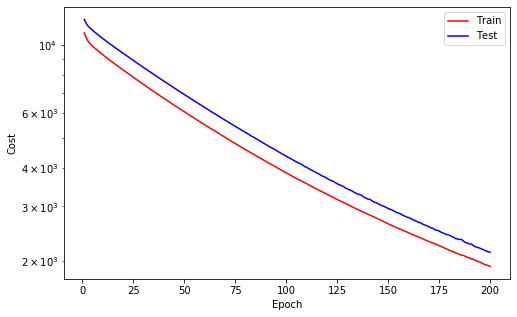



Epoch   201
Train_cost  = 1906.6664 | Test_cost  = 2118.0136 | 




Epoch   202
Train_cost  = 1896.0770 | Test_cost  = 2099.7871 | 




Epoch   203
Train_cost  = 1884.0131 | Test_cost  = 2092.8039 | 




Epoch   204
Train_cost  = 1874.7172 | Test_cost  = 2077.3666 | 




Epoch   205
Train_cost  = 1860.4907 | Test_cost  = 2063.6018 | 




Epoch   206
Train_cost  = 1847.2160 | Test_cost  = 2054.3752 | 




Epoch   207
Train_cost  = 1836.6323 | Test_cost  = 2040.7844 | 




Epoch   208
Train_cost  = 1827.3254 | Test_cost  = 2037.0450 | 




Epoch   209
Train_cost  = 1819.1185 | Test_cost  = 2020.6612 | 




Epoch   210
Train_cost  = 1806.4993 | Test_cost  = 2010.4782 | 




Epoch   211
Train_cost  = 1795.0728 | Test_cost  = 1995.3831 | 




Epoch   212
Train_cost  = 1787.2435 | Test_cost  = 1990.6860 | 




Epoch   213
Train_cost  = 1778.3091 | Test_cost  = 1972.4856 | 




Epoch   214
Train_cost  = 1767.9660 | Test_cost  = 1970.3047 | 




Epoch   215
Train_cost  = 1760.8082 | Test_cost  = 1954.6300 | 




Epoch   216
Train_cost  = 1750.1708 | Test_cost  = 1940.9208 | 




Epoch   217
Train_cost  = 1740.3524 | Test_cost  = 1936.9555 | 




Epoch   218
Train_cost  = 1738.3376 | Test_cost  = 1911.8761 | 




Epoch   219
Train_cost  = 1727.0306 | Test_cost  = 1912.3100 | 
==> EarlyStop patience =  1 | Best test_cost: 1911.8761




Epoch   220
Train_cost  = 1714.7041 | Test_cost  = 1892.2398 | 


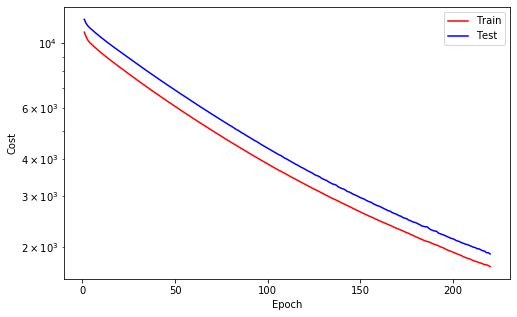



Epoch   221
Train_cost  = 1700.2796 | Test_cost  = 1879.0707 | 




Epoch   222
Train_cost  = 1689.1654 | Test_cost  = 1874.2861 | 




Epoch   223
Train_cost  = 1680.3335 | Test_cost  = 1861.9485 | 




Epoch   224
Train_cost  = 1671.5340 | Test_cost  = 1856.1044 | 




Epoch   225
Train_cost  = 1661.6461 | Test_cost  = 1842.8100 | 




Epoch   226
Train_cost  = 1652.3813 | Test_cost  = 1831.2626 | 




Epoch   227
Train_cost  = 1643.1488 | Test_cost  = 1824.8461 | 




Epoch   228
Train_cost  = 1635.7488 | Test_cost  = 1810.4148 | 




Epoch   229
Train_cost  = 1627.3761 | Test_cost  = 1813.8914 | 
==> EarlyStop patience =  1 | Best test_cost: 1810.4148




Epoch   230
Train_cost  = 1620.5541 | Test_cost  = 1798.8955 | 




Epoch   231
Train_cost  = 1613.5761 | Test_cost  = 1793.4859 | 




Epoch   232
Train_cost  = 1604.3275 | Test_cost  = 1768.4651 | 




Epoch   233
Train_cost  = 1593.8841 | Test_cost  = 1758.4944 | 




Epoch   234
Train_cost  = 1585.7292 | Test_cost  = 1753.0450 | 




Epoch   235
Train_cost  = 1578.6626 | Test_cost  = 1743.1794 | 




Epoch   236
Train_cost  = 1569.2988 | Test_cost  = 1738.3675 | 




Epoch   237
Train_cost  = 1565.1629 | Test_cost  = 1728.0065 | 




Epoch   238
Train_cost  = 1556.7060 | Test_cost  = 1731.6361 | 
==> EarlyStop patience =  1 | Best test_cost: 1728.0065




Epoch   239
Train_cost  = 1552.4336 | Test_cost  = 1712.7168 | 




Epoch   240
Train_cost  = 1542.0401 | Test_cost  = 1702.6678 | 


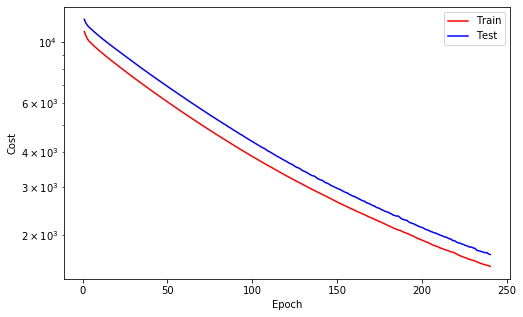



Epoch   241
Train_cost  = 1533.8782 | Test_cost  = 1690.3972 | 




Epoch   242
Train_cost  = 1527.8988 | Test_cost  = 1683.5739 | 




Epoch   243
Train_cost  = 1519.7677 | Test_cost  = 1675.0699 | 




Epoch   244
Train_cost  = 1512.1948 | Test_cost  = 1655.6067 | 




Epoch   245
Train_cost  = 1506.3757 | Test_cost  = 1650.2115 | 




Epoch   246
Train_cost  = 1499.9373 | Test_cost  = 1640.7505 | 




Epoch   247
Train_cost  = 1488.5477 | Test_cost  = 1629.8233 | 




Epoch   248
Train_cost  = 1477.7621 | Test_cost  = 1616.9222 | 




Epoch   249
Train_cost  = 1467.3172 | Test_cost  = 1618.5290 | 
==> EarlyStop patience =  1 | Best test_cost: 1616.9222




Epoch   250
Train_cost  = 1458.9506 | Test_cost  = 1613.5052 | 




Epoch   251
Train_cost  = 1450.0244 | Test_cost  = 1602.6636 | 




Epoch   252
Train_cost  = 1445.0216 | Test_cost  = 1598.6472 | 




Epoch   253
Train_cost  = 1443.9148 | Test_cost  = 1585.7963 | 




Epoch   254
Train_cost  = 1443.9113 | Test_cost  = 1585.1173 | 




Epoch   255
Train_cost  = 1439.9615 | Test_cost  = 1576.2868 | 




Epoch   256
Train_cost  = 1430.5656 | Test_cost  = 1571.7647 | 




Epoch   257
Train_cost  = 1425.6600 | Test_cost  = 1551.8932 | 




Epoch   258
Train_cost  = 1414.4758 | Test_cost  = 1532.2467 | 




Epoch   259
Train_cost  = 1401.1049 | Test_cost  = 1552.0141 | 
==> EarlyStop patience =  1 | Best test_cost: 1532.2467




Epoch   260
Train_cost  = 1396.7785 | Test_cost  = 1527.0614 | 


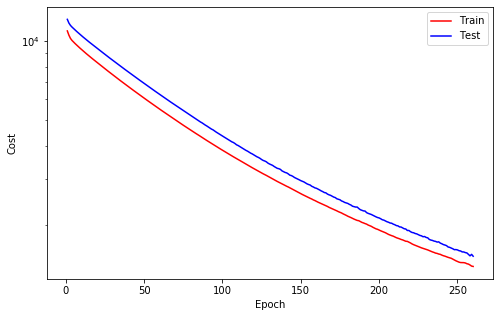



Epoch   261
Train_cost  = 1383.7307 | Test_cost  = 1518.1127 | 




Epoch   262
Train_cost  = 1377.3782 | Test_cost  = 1519.9748 | 
==> EarlyStop patience =  1 | Best test_cost: 1518.1127




Epoch   263
Train_cost  = 1371.4965 | Test_cost  = 1498.6941 | 




Epoch   264
Train_cost  = 1360.8805 | Test_cost  = 1508.1259 | 
==> EarlyStop patience =  1 | Best test_cost: 1498.6941




Epoch   265
Train_cost  = 1353.2380 | Test_cost  = 1489.7580 | 




Epoch   266
Train_cost  = 1343.7013 | Test_cost  = 1487.8266 | 




Epoch   267
Train_cost  = 1336.8928 | Test_cost  = 1485.0338 | 




Epoch   268
Train_cost  = 1331.1088 | Test_cost  = 1468.7065 | 




Epoch   269
Train_cost  = 1325.4016 | Test_cost  = 1472.7718 | 
==> EarlyStop patience =  1 | Best test_cost: 1468.7065




Epoch   270
Train_cost  = 1320.0514 | Test_cost  = 1453.6241 | 




Epoch   271
Train_cost  = 1312.2601 | Test_cost  = 1458.4274 | 
==> EarlyStop patience =  1 | Best test_cost: 1453.6241




Epoch   272
Train_cost  = 1306.7033 | Test_cost  = 1451.8386 | 




Epoch   273
Train_cost  = 1304.7743 | Test_cost  = 1423.5245 | 




Epoch   274
Train_cost  = 1301.3463 | Test_cost  = 1438.9098 | 
==> EarlyStop patience =  1 | Best test_cost: 1423.5245




Epoch   275
Train_cost  = 1296.9198 | Test_cost  = 1429.9055 | 
==> EarlyStop patience =  2 | Best test_cost: 1423.5245




Epoch   276
Train_cost  = 1292.5955 | Test_cost  = 1433.5749 | 
==> EarlyStop patience =  3 | Best test_cost: 1423.5245




Epoch   277
Train_cost  = 1287.2748 | Test_cost  = 1411.0096 | 




Epoch   278
Train_cost  = 1276.7810 | Test_cost  = 1398.0572 | 




Epoch   279
Train_cost  = 1271.0191 | Test_cost  = 1405.7343 | 
==> EarlyStop patience =  1 | Best test_cost: 1398.0572




Epoch   280
Train_cost  = 1262.7058 | Test_cost  = 1398.1013 | 


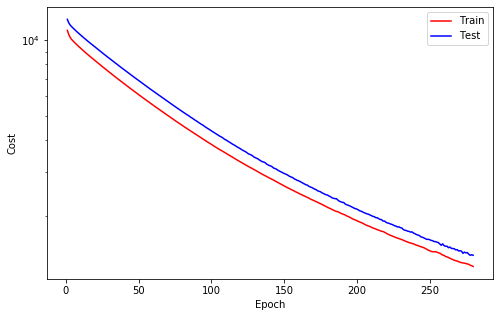

==> EarlyStop patience =  2 | Best test_cost: 1398.0572




Epoch   281
Train_cost  = 1256.0922 | Test_cost  = 1399.4401 | 
==> EarlyStop patience =  3 | Best test_cost: 1398.0572




Epoch   282
Train_cost  = 1248.9164 | Test_cost  = 1380.8601 | 




Epoch   283
Train_cost  = 1243.6136 | Test_cost  = 1372.1554 | 




Epoch   284
Train_cost  = 1241.5168 | Test_cost  = 1365.2470 | 




Epoch   285
Train_cost  = 1232.1738 | Test_cost  = 1376.1283 | 
==> EarlyStop patience =  1 | Best test_cost: 1365.2470




Epoch   286
Train_cost  = 1230.9378 | Test_cost  = 1364.3656 | 




Epoch   287
Train_cost  = 1229.6107 | Test_cost  = 1345.6999 | 




Epoch   288
Train_cost  = 1231.0998 | Test_cost  = 1356.4523 | 
==> EarlyStop patience =  1 | Best test_cost: 1345.6999




Epoch   289
Train_cost  = 1228.9485 | Test_cost  = 1358.9411 | 
==> EarlyStop patience =  2 | Best test_cost: 1345.6999




Epoch   290
Train_cost  = 1213.9288 | Test_cost  = 1331.4999 | 




Epoch   291
Train_cost  = 1206.1343 | Test_cost  = 1320.7173 | 




Epoch   292
Train_cost  = 1195.8630 | Test_cost  = 1320.7546 | 
==> EarlyStop patience =  1 | Best test_cost: 1320.7173




Epoch   293
Train_cost  = 1189.9682 | Test_cost  = 1315.5885 | 




Epoch   294
Train_cost  = 1180.9678 | Test_cost  = 1310.6737 | 




Epoch   295
Train_cost  = 1179.6624 | Test_cost  = 1301.6325 | 




Epoch   296
Train_cost  = 1169.9157 | Test_cost  = 1307.0111 | 
==> EarlyStop patience =  1 | Best test_cost: 1301.6325




Epoch   297
Train_cost  = 1163.0364 | Test_cost  = 1292.7487 | 




Epoch   298
Train_cost  = 1157.6966 | Test_cost  = 1293.6118 | 
==> EarlyStop patience =  1 | Best test_cost: 1292.7487




Epoch   299
Train_cost  = 1154.4498 | Test_cost  = 1272.4943 | 




Epoch   300
Train_cost  = 1149.2832 | Test_cost  = 1270.6379 | 


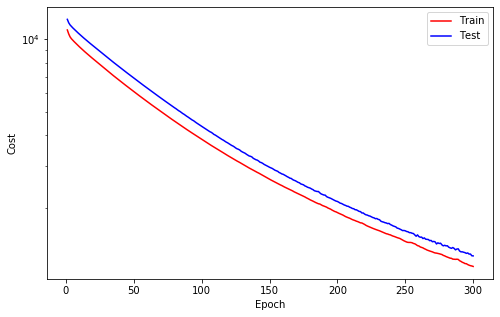



Epoch   301
Train_cost  = 1147.8395 | Test_cost  = 1271.6291 | 
==> EarlyStop patience =  1 | Best test_cost: 1270.6379




Epoch   302
Train_cost  = 1136.3757 | Test_cost  = 1262.4958 | 




Epoch   303
Train_cost  = 1134.8165 | Test_cost  = 1257.1735 | 




Epoch   304
Train_cost  = 1123.1025 | Test_cost  = 1241.8231 | 




Epoch   305
Train_cost  = 1118.0598 | Test_cost  = 1272.5927 | 
==> EarlyStop patience =  1 | Best test_cost: 1241.8231




Epoch   306
Train_cost  = 1111.8450 | Test_cost  = 1229.5391 | 




Epoch   307
Train_cost  = 1103.2506 | Test_cost  = 1231.0652 | 
==> EarlyStop patience =  1 | Best test_cost: 1229.5391




Epoch   308
Train_cost  = 1103.7333 | Test_cost  = 1232.7647 | 
==> EarlyStop patience =  2 | Best test_cost: 1229.5391




Epoch   309
Train_cost  = 1094.6802 | Test_cost  = 1233.5685 | 
==> EarlyStop patience =  3 | Best test_cost: 1229.5391




Epoch   310
Train_cost  = 1090.3064 | Test_cost  = 1232.8892 | 
==> EarlyStop patience =  4 | Best test_cost: 1229.5391




Epoch   311
Train_cost  = 1087.7583 | Test_cost  = 1212.9789 | 




Epoch   312
Train_cost  = 1088.2341 | Test_cost  = 1219.0016 | 
==> EarlyStop patience =  1 | Best test_cost: 1212.9789




Epoch   313
Train_cost  = 1093.3979 | Test_cost  = 1204.9764 | 




Epoch   314
Train_cost  = 1084.0245 | Test_cost  = 1208.6697 | 
==> EarlyStop patience =  1 | Best test_cost: 1204.9764




Epoch   315
Train_cost  = 1079.3479 | Test_cost  = 1203.5166 | 




Epoch   316
Train_cost  = 1072.1549 | Test_cost  = 1190.2889 | 




Epoch   317
Train_cost  = 1065.2583 | Test_cost  = 1176.3228 | 




Epoch   318
Train_cost  = 1063.7576 | Test_cost  = 1182.9796 | 
==> EarlyStop patience =  1 | Best test_cost: 1176.3228




Epoch   319
Train_cost  = 1056.8455 | Test_cost  = 1194.7400 | 
==> EarlyStop patience =  2 | Best test_cost: 1176.3228




Epoch   320
Train_cost  = 1052.0537 | Test_cost  = 1181.0077 | 


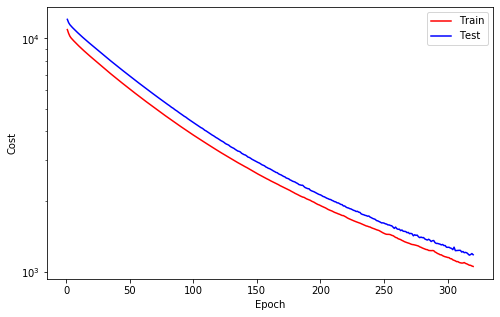

==> EarlyStop patience =  3 | Best test_cost: 1176.3228




Epoch   321
Train_cost  = 1048.1298 | Test_cost  = 1166.0849 | 




Epoch   322
Train_cost  = 1041.2586 | Test_cost  = 1165.2966 | 




Epoch   323
Train_cost  = 1034.6226 | Test_cost  = 1171.2071 | 
==> EarlyStop patience =  1 | Best test_cost: 1165.2966




Epoch   324
Train_cost  = 1029.7666 | Test_cost  = 1151.6803 | 




Epoch   325
Train_cost  = 1030.8723 | Test_cost  = 1148.8043 | 




Epoch   326
Train_cost  = 1025.5532 | Test_cost  = 1154.0986 | 
==> EarlyStop patience =  1 | Best test_cost: 1148.8043




Epoch   327
Train_cost  = 1020.3052 | Test_cost  = 1149.5721 | 
==> EarlyStop patience =  2 | Best test_cost: 1148.8043




Epoch   328
Train_cost  = 1013.3901 | Test_cost  = 1136.3265 | 




Epoch   329
Train_cost  = 1006.5137 | Test_cost  = 1140.5736 | 
==> EarlyStop patience =  1 | Best test_cost: 1136.3265




Epoch   330
Train_cost  = 997.3815 | Test_cost  = 1130.2659 | 




Epoch   331
Train_cost  = 989.5578 | Test_cost  = 1124.5998 | 




Epoch   332
Train_cost  = 984.4257 | Test_cost  = 1116.8259 | 




Epoch   333
Train_cost  = 981.4929 | Test_cost  = 1132.5490 | 
==> EarlyStop patience =  1 | Best test_cost: 1116.8259




Epoch   334
Train_cost  = 981.0762 | Test_cost  = 1112.2789 | 




Epoch   335
Train_cost  = 976.9405 | Test_cost  = 1116.1395 | 
==> EarlyStop patience =  1 | Best test_cost: 1112.2789




Epoch   336
Train_cost  = 969.3844 | Test_cost  = 1103.7567 | 




Epoch   337
Train_cost  = 964.7169 | Test_cost  = 1097.6897 | 




Epoch   338
Train_cost  = 965.1897 | Test_cost  = 1102.1907 | 
==> EarlyStop patience =  1 | Best test_cost: 1097.6897




Epoch   339
Train_cost  = 959.1457 | Test_cost  = 1099.2075 | 
==> EarlyStop patience =  2 | Best test_cost: 1097.6897




Epoch   340
Train_cost  = 952.0815 | Test_cost  = 1092.9415 | 


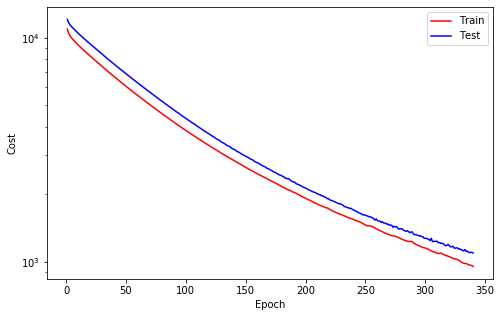



Epoch   341
Train_cost  = 950.8288 | Test_cost  = 1080.3963 | 




Epoch   342
Train_cost  = 960.7378 | Test_cost  = 1085.4343 | 
==> EarlyStop patience =  1 | Best test_cost: 1080.3963




Epoch   343
Train_cost  = 956.1114 | Test_cost  = 1083.0998 | 
==> EarlyStop patience =  2 | Best test_cost: 1080.3963




Epoch   344
Train_cost  = 957.2667 | Test_cost  = 1065.8977 | 




Epoch   345
Train_cost  = 958.5159 | Test_cost  = 1066.5367 | 
==> EarlyStop patience =  1 | Best test_cost: 1065.8977




Epoch   346
Train_cost  = 943.9389 | Test_cost  = 1061.3475 | 




Epoch   347
Train_cost  = 937.7247 | Test_cost  = 1071.6979 | 
==> EarlyStop patience =  1 | Best test_cost: 1061.3475




Epoch   348
Train_cost  = 929.4516 | Test_cost  = 1058.8334 | 




Epoch   349
Train_cost  = 924.5100 | Test_cost  = 1048.4629 | 




Epoch   350
Train_cost  = 918.5216 | Test_cost  = 1057.6582 | 
==> EarlyStop patience =  1 | Best test_cost: 1048.4629




Epoch   351
Train_cost  = 911.0222 | Test_cost  = 1052.5482 | 
==> EarlyStop patience =  2 | Best test_cost: 1048.4629




Epoch   352
Train_cost  = 909.3071 | Test_cost  = 1048.9914 | 
==> EarlyStop patience =  3 | Best test_cost: 1048.4629




Epoch   353
Train_cost  = 902.0644 | Test_cost  = 1049.4728 | 
==> EarlyStop patience =  4 | Best test_cost: 1048.4629




Epoch   354
Train_cost  = 899.7545 | Test_cost  = 1031.2430 | 




Epoch   355
Train_cost  = 895.2453 | Test_cost  = 1054.1799 | 
==> EarlyStop patience =  1 | Best test_cost: 1031.2430




Epoch   356
Train_cost  = 891.5465 | Test_cost  = 1029.4584 | 




Epoch   357
Train_cost  = 893.5791 | Test_cost  = 1031.4435 | 
==> EarlyStop patience =  1 | Best test_cost: 1029.4584




Epoch   358
Train_cost  = 890.0242 | Test_cost  = 1036.3618 | 
==> EarlyStop patience =  2 | Best test_cost: 1029.4584




Epoch   359
Train_cost  = 890.3624 | Test_cost  = 1024.5980 | 




Epoch   360
Train_cost  = 888.8942 | Test_cost  = 1018.0854 | 


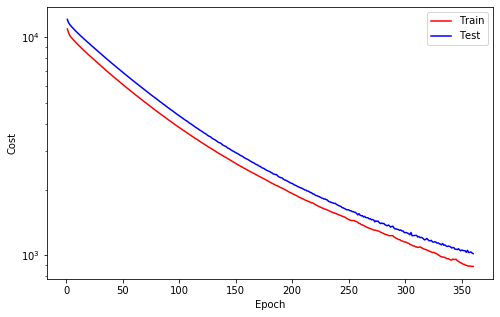



Epoch   361
Train_cost  = 884.0149 | Test_cost  = 1021.0588 | 
==> EarlyStop patience =  1 | Best test_cost: 1018.0854




Epoch   362
Train_cost  = 882.1247 | Test_cost  = 1012.4262 | 




Epoch   363
Train_cost  = 878.2626 | Test_cost  = 1020.1654 | 
==> EarlyStop patience =  1 | Best test_cost: 1012.4262




Epoch   364
Train_cost  = 871.7372 | Test_cost  = 1006.1620 | 




Epoch   365
Train_cost  = 863.0277 | Test_cost  = 1004.0294 | 




Epoch   366
Train_cost  = 862.7395 | Test_cost  = 997.0688 | 




Epoch   367
Train_cost  = 857.9704 | Test_cost  = 1011.6139 | 
==> EarlyStop patience =  1 | Best test_cost: 997.0688




Epoch   368
Train_cost  = 859.4962 | Test_cost  = 1006.8684 | 
==> EarlyStop patience =  2 | Best test_cost: 997.0688




Epoch   369
Train_cost  = 858.4716 | Test_cost  = 987.1619 | 




Epoch   370
Train_cost  = 857.8913 | Test_cost  = 985.6229 | 




Epoch   371
Train_cost  = 864.4691 | Test_cost  = 985.7324 | 
==> EarlyStop patience =  1 | Best test_cost: 985.6229




Epoch   372
Train_cost  = 854.0671 | Test_cost  = 1003.2163 | 
==> EarlyStop patience =  2 | Best test_cost: 985.6229




Epoch   373
Train_cost  = 861.3170 | Test_cost  = 991.7217 | 
==> EarlyStop patience =  3 | Best test_cost: 985.6229




Epoch   374
Train_cost  = 849.1223 | Test_cost  = 974.4188 | 




Epoch   375
Train_cost  = 837.5022 | Test_cost  = 977.5481 | 
==> EarlyStop patience =  1 | Best test_cost: 974.4188




Epoch   376
Train_cost  = 831.7384 | Test_cost  = 953.6475 | 




Epoch   377
Train_cost  = 829.7054 | Test_cost  = 978.2648 | 
==> EarlyStop patience =  1 | Best test_cost: 953.6475




Epoch   378
Train_cost  = 829.9647 | Test_cost  = 973.9299 | 
==> EarlyStop patience =  2 | Best test_cost: 953.6475




Epoch   379
Train_cost  = 817.0081 | Test_cost  = 970.9034 | 
==> EarlyStop patience =  3 | Best test_cost: 953.6475




Epoch   380
Train_cost  = 813.8650 | Test_cost  = 966.5686 | 


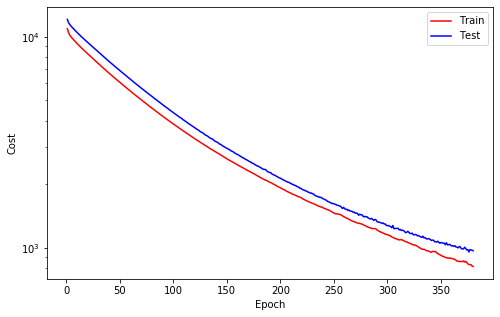

==> EarlyStop patience =  4 | Best test_cost: 953.6475




Epoch   381
Train_cost  = 808.9231 | Test_cost  = 959.9882 | 
==> EarlyStop patience =  5 | Best test_cost: 953.6475
==> Execute Early Stopping at epoch: 381 | Best test_cost: 953.6475
==> Best model is saved at model


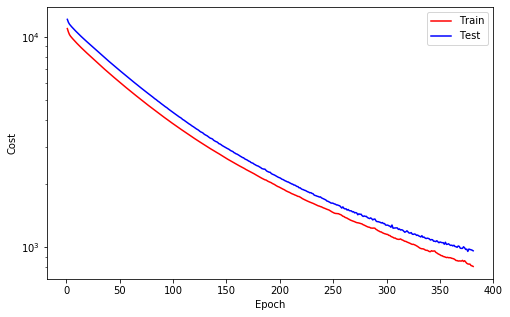

In [15]:
while True :
    train_cost= loop_fn("train",train_set,trainloader,model,criterion,optimizer,device)
    with torch.no_grad():
        test_cost= loop_fn("test",test_set,testloader,model,criterion,optimizer,device)

    callback.log(train_cost, test_cost)


    callback.save_checkpoint()


    callback.cost_runtime_plotting()



    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break

In [16]:
from utils import data4pred,pred4pred

In [17]:
train_forecast_set = TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",1)
trainforcastloader= DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",1)
testforcastloader= DataLoader(test_forecast_set)



(N, S, F): (2611, 1, 1)
Note: last 0 data excluded

(N, S, F): (652, 1, 1)
Note: last 0 data excluded



C:\Users\Rahmat\anaconda3\envs\jcop\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'test')

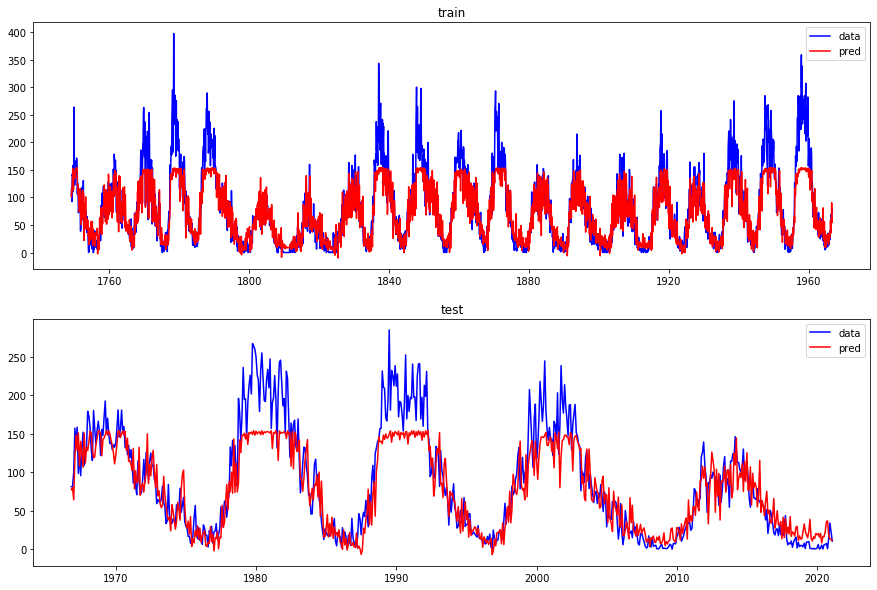

In [18]:
# data4pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set,trainforcastloader,device)
plt.title("train")


plt.subplot(212)
data4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")

Text(0.5, 1.0, 'test')

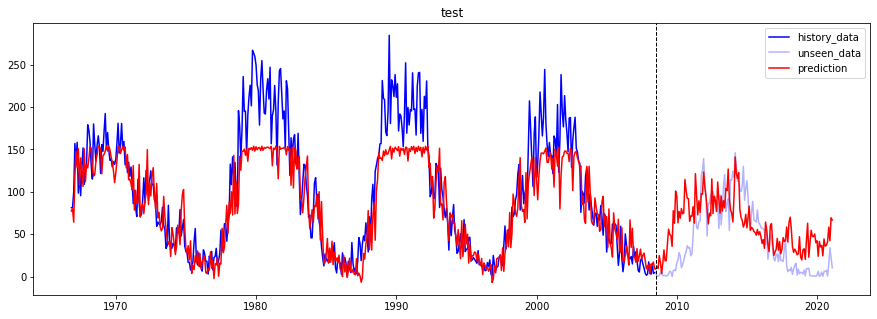

In [19]:
plt.figure(figsize=(15,5))

pred4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")